In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

## Katz Centrality

Moving on from $d_{degree}$, we now analyze the ability of GCNs to learn Katz Centrality. The Katz Centrality of matrix $A\in{}R^{n\times{}n}$ is defined as

$$d_{Katz} = \sum_{k=0}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1}$$

where necesarily $0\leq{}\alpha{}<\frac{1}{\lambda_{1}}$ [13]. Let $\lambda_{i}$ be the eigenvalues of $A$ such that $\lambda_{1}\geq{}\lambda_{2}\geq{}...\geq{}\lambda_{n}$. If $\alpha\neq{}\frac{1}{\lambda_{i}}$, the above expression is equivalent to $(I - \alpha{}A^{T})^{-1} \vec{1}$, which we show below.

$$\sum_{k=0}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1} = (I - \alpha{}A^{T})^{-1}\vec{1}$$
$$(I - \alpha{}A^{T}) (\sum_{k=0}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1}) = \vec{1}$$
$$\sum_{k=0}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1} - \sum_{k=1}^{\infty}\alpha^{k}(A^{T})^{k}\vec{1} = \vec{1}$$
$$I = I$$

Katz Centrality is best understood as a hybridization of Degree Centrality (for small $\alpha{}$) and of Eigenvector Centrality (for large $\alpha$). 

$$d_{eig} = \lim_{k\rightarrow{}\infty}(\frac{1}{|\lambda_{1}|}A^{T})^{k}\vec{1}$$

As a consequence of Perron-Frobenius theorem, Eigenvector Centrality is only well-definied for strongly connected networks. Katz Centrality addresses this by adding a constant term to each vertex. If the network is strongly connected, then the two are equivalent under certain conditions, namely:

$$\lim_{\alpha{}\rightarrow{}\frac{1}{|\lambda_{1}|}}d_{Katz} = \sum_{k=0}^{\infty}(\frac{1}{|\lambda_{1}|}A^{T})^{k}\vec{1}$$
$$=1 + (c_{1}v_{1}(1+1+...) + c_{2}v_{2}(\frac{\lambda_{2}}{|\lambda_{1}|} + (\frac{\lambda_{2}}{|\lambda_{1}|})^{2} + ...) + ...)\vec{1}$$
$\frac{|\lambda_{2}|}{|\lambda_{1}|}<1$, so the first term dominates in the infinite sum. Since $\lambda_{1}>0$, 
$$\approx{} 1 + cv_{1} \approx{} cv_{1} = c\lim_{k\rightarrow{}\infty}(\frac{1}{|\lambda_{1}|}A^{T})^{k}\vec{1} $$

Constant $c$ vanishes anyway in the normalization. Choice of $\alpha{}<\frac{1}{|\lambda_{1}|}$ ensures convergence. For our purposes, $\alpha = \frac{1}{1.01|\lambda_{1}|}$.

### Dataset

SBM parameters are the same as before.

In [2]:
num_graphs = 3000
d = []

for _ in range(num_graphs):
    n = torch.randint(50,100,(5,))
    p = 1/n + (10/n - 1/n) * torch.rand((5,5))
    p = .5 * (p + p.T)
    x,edges = torch.randn((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

### Efficacy of Katz Iterations

As a point of comparison, we manually compute Katz Iterations up to $k=100$ and report convergence.

In [3]:
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    v = 1/(1.01*torch.norm(torch.eig(adj.to_dense())[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T),dim=1)
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

KeyboardInterrupt: 

In [7]:
def KatzIterations(X,edge_index,k=1024):
    error = torch.zeros((k,X.shape[0])).cuda()
    output = torch.zeros(k).cuda()
    adj = torch_sparse.SparseTensor(row=edge_index[0],col=edge_index[1]).cuda()
    alpha = 1/(1.01 * torch.max(torch.norm(torch.eig(adj.to_dense())[0],dim=1)))

    error[0] = X.squeeze()
    Z = torch.ones_like(X)
    for i in range(1,k):
        X = alpha * torch_sparse.matmul(adj,X)
        Z = Z + X
        error[i] = Z.squeeze()
    for i in range(k-1,-1,-1):
        output[i] = scaled_L1(error[-1],error[i],torch.zeros(X.shape[0]).cuda().long())
    return output

In [8]:
for idx,data in enumerate(test):
    if idx==0:
        error = KatzIterations(data.x.cuda(),data.edge_index,100)
        torch.cuda.empty_cache()
    else:
        error += KatzIterations(data.x.cuda(),data.edge_index,100)
error/=(idx+1)

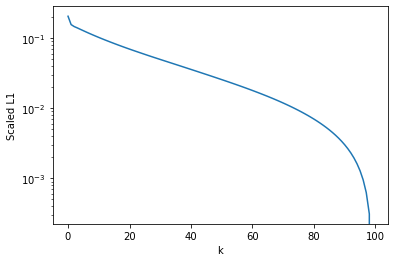

In [9]:
plt.semilogy(error.cpu())
plt.ylabel('Scaled L1')
plt.xlabel('k');

It takes around $100$ Katz iterations to reach a loss of $1e^{-3}$; for reference, this would correspond to a GCN with depth $l=100$. Below, we train GraphConv and EdgeConv to minimize $L(\vec{x},\vec{d}_{Katz})$ on unweighted-undirected, weighted-undirected, and weighted-directed networks. 

### Unweighted, Undirected

In [10]:
for idx,G in enumerate(d):    
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    v = 1/(1.01*torch.norm(torch.eig(adj.to_dense())[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T),dim=1)
    
    # Set target
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [11]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,4).cuda()
Edge = EdgeConv(1,32,1,4).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()

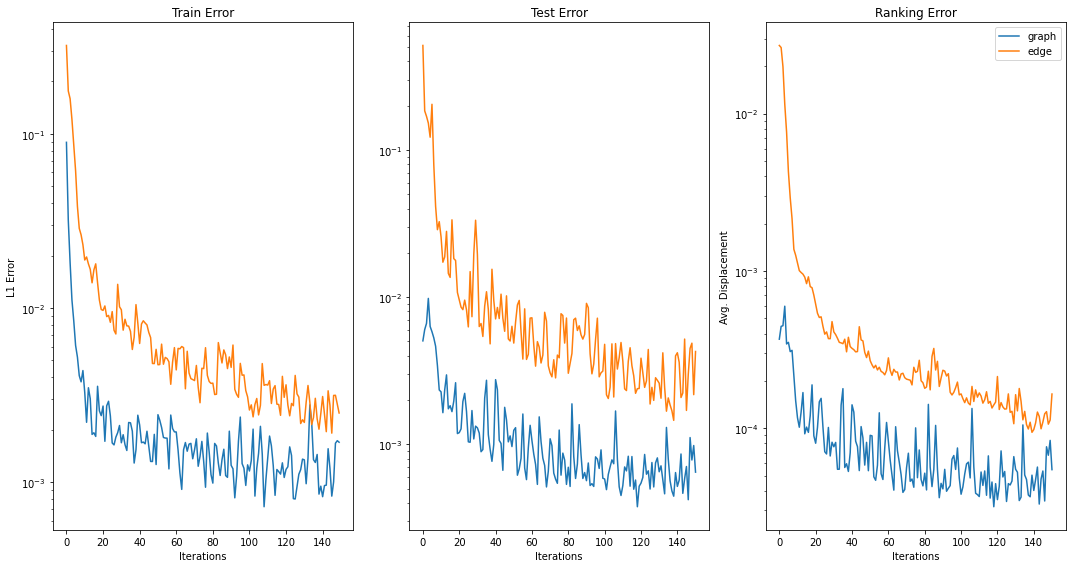

In [12]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='graph')
plt.semilogy(edge_metrics[2],label='edge')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

### Weighted, Undirected

In [13]:
for idx,G in enumerate(d):
    # Assign weights and symmetrize
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=torch.rand(G.edge_index[0].shape))
    adj = .5 * (adj.to_dense() + adj.to_dense().T)
    
    # Compute Katz Centrality
    v = 1/(1.01*torch.norm(torch.eig(adj)[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj),dim=1)
    
    # Set as target
    G.y = y
    G.edge_weight = torch_sparse.SparseTensor.from_dense(adj).coo()[2]
    d[idx] = G

    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [14]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,4).cuda()
Edge = EdgeConv(1,32,1,4).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()

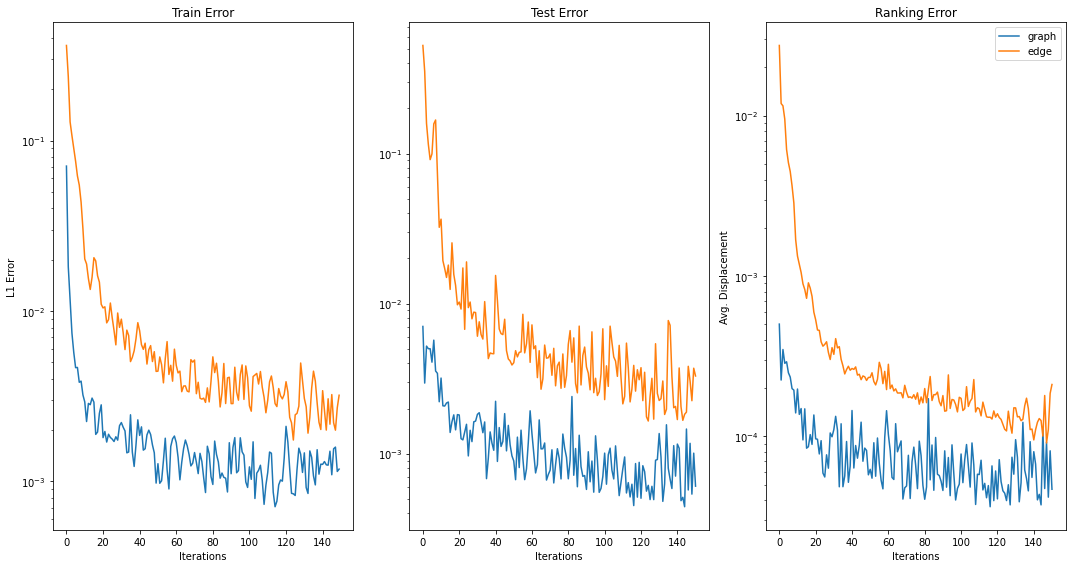

In [15]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='graph')
plt.semilogy(edge_metrics[2],label='edge')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

### Weighted, Directed

In [16]:
for idx,G in enumerate(d):
    # Assign weights
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=torch.rand(G.edge_index[0].shape))
    adj = adj.to_dense()
    
    # Compute Katz Centrality
    v = 1/(1.01*torch.norm(torch.eig(adj)[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj) - torch.eye(adj.size(0)),dim=1)
    
    # Set as target
    G.y = y
    G.edge_weight = torch_sparse.SparseTensor.from_dense(adj).coo()[2]
    d[idx] = G

    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [17]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,4).cuda()
Edge = EdgeConv(1,32,1,4).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()

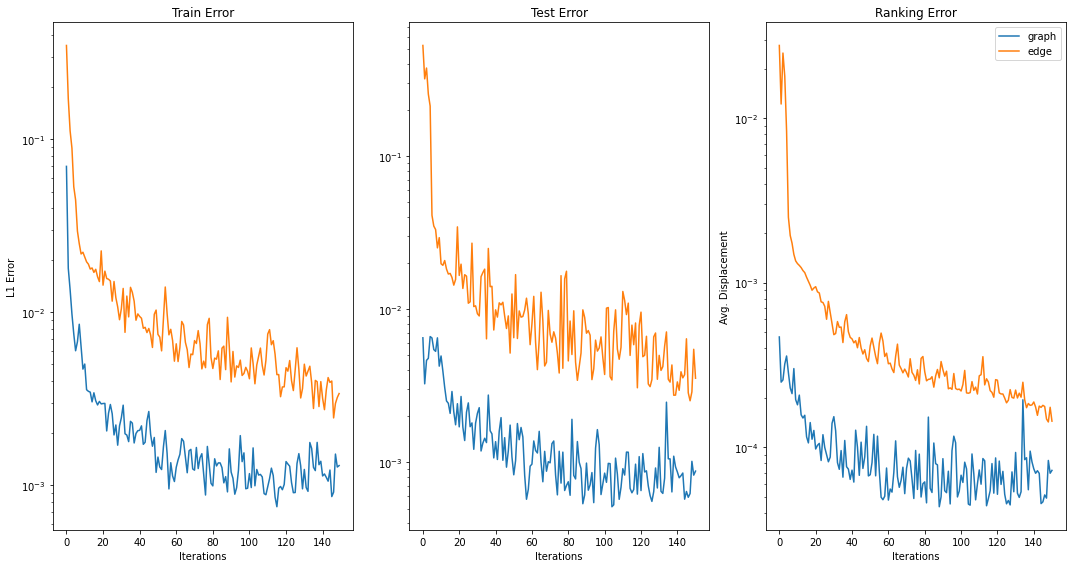

In [18]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='graph')
plt.semilogy(edge_metrics[2],label='edge')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

### Overview

Since Katz Centrality inherently involves multiple aggreations, we increased the model depth from 1 to 4, which in turn necesitated a larger learning rate and greater epochs. Loss on $d_{Katz}$ is comparable to that for $d_{degree}$, and it is far better than the equivalent number of Katz Iterations. EdgeConv converges much slower while requiring nearly twice the runtime.

### But What If the Data is Low-Density?

Our results only hold for high-density SBMs wherein the ratio of leading eigenvalues is relatively small. As established, this ratio controls the rate of convergence of $A^{k}\vec{x}$ to the dominant eigenvector of $A$. Graph convolution involves taking succesive powers of the adjancency matrix and passing its span through a differentiable $\Theta$; in fact, Linear GCNs can be considered a weighted form of the Power Iteration method i.e:

$$X^{l+1} = AX^{l}\Theta^{l}$$

where $X\in{}R^{|V|\times{}n}$ is the network feature matrix. So, with this relation in mind, we are naturally interested in how the spectral properties of a network impact GCN convergence. We generate several new SBM datasets by decreasing the intra and inter-cluster probabilities, which leads to a lower graph density. This also makes these graphs more likely to be disconnected, hence the need for Katz Centrality (as opposed to Eigenvalue). For now, we only consider the unweighted, undirected case, as it's the simplest. 

#### $p \in{} [\frac{1}{n},\frac{1}{2n}]$

Average density of $.020$ with $E[\frac{|\lambda_{1}|}{|\lambda_{2}|}]\approx{}.66$

In [2]:
num_graphs = 3000
d = []

for _ in range(num_graphs):
    
    # Set Cluster sizes and connection probilities: [1/n,1/2n]
    n = torch.randint(50,100,(5,))
    p = 1/n + (1/n) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

In [3]:
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    v = 1/(1.01*torch.norm(torch.eig(adj.to_dense())[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T),dim=1)
    
    # Set as target
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [4]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,4).cuda()
Edge = EdgeConv(1,32,1,4).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()

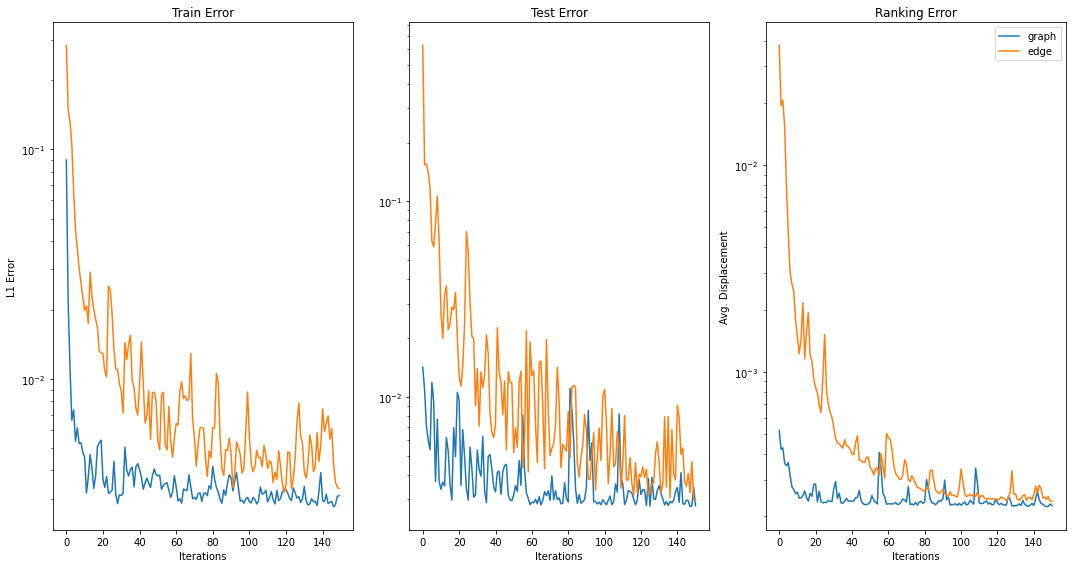

In [5]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='graph')
plt.semilogy(edge_metrics[2],label='edge')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

#### $p\in{}[\frac{1}{50n},\frac{1}{n}]$

Average density of $.008$ with $E[\frac{|\lambda_{1}|}{|\lambda_{2}|}]\approx{}.925$

In [6]:
num_graphs = 3000
d = []

for _ in range(num_graphs):
    
    # Set Cluster sizes and connection probabilties: [1/50n,1/n]
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    
    # Generate SBM
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    # Write to Data object
    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

In [7]:
for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    
    # Compute Katz Centrality
    v = 1/(1.01*torch.norm(torch.eig(adj.to_dense())[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T),dim=1)
    
    # Set as target
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]

train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [8]:
torch.manual_seed(0)

Graph = GraphConv(1,32,1,4).cuda()
Edge = EdgeConv(1,32,1,4).cuda()

graph_metrics = train_loop(Graph,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()
edge_metrics = train_loop(Edge,train_loader,test_loader,150,lr=1e-1)
torch.cuda.empty_cache()

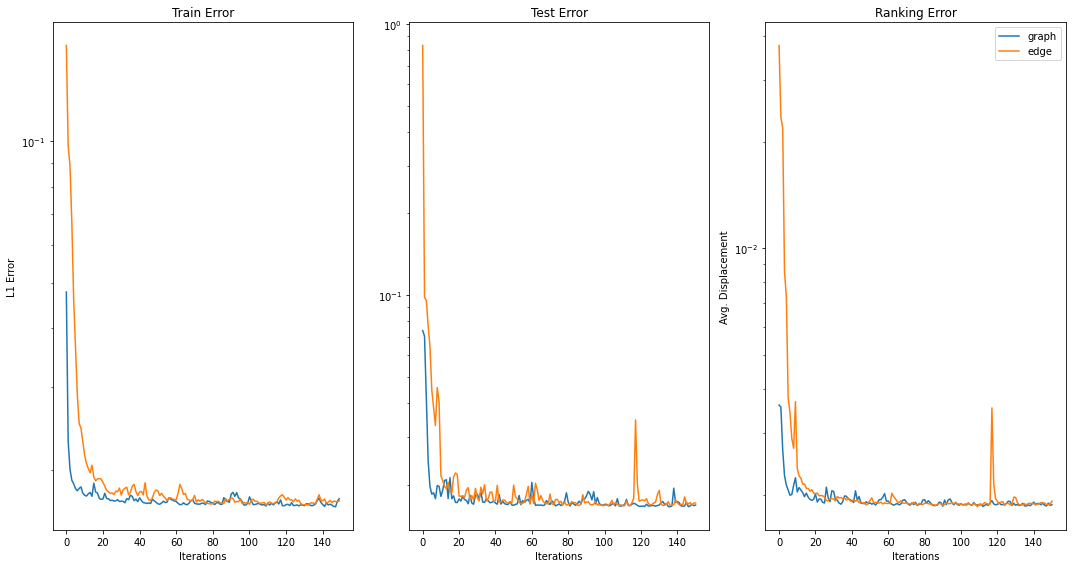

In [9]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.semilogy(graph_metrics[0])
plt.semilogy(edge_metrics[0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
plt.semilogy(graph_metrics[1])
plt.semilogy(edge_metrics[1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
plt.semilogy(graph_metrics[2],label='graph')
plt.semilogy(edge_metrics[2],label='edge')
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout();

### Overview

As the eigenvalue ratio increases, there is a clear degredation in GCN performance, going from order $10^{-3}$ on the test loss when $\frac{|\lambda_2{}|}{|\lambda_{1}|}\approx{}.35$ to $10^{-2}$ when $\frac{|\lambda_2{}|}{|\lambda_{1}|}\approx{}.92$. A similar statement holds for the rank displacement. Since EdgeConv offers no benefits in this scenario, we exclude it from any further experiments.